In [ ]:
! apt-get install openjdk-8-jdk-headless -qq > /dev/null
! wget -q https://archive.apache.org/dist/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
! tar xf spark-3.5.4-bin-hadoop3.tgz
! pip install -q findspark

In [ ]:
! du -sh spark-3.5.4-bin-hadoop3.tgz

383M	spark-3.5.4-bin-hadoop3.tgz


In [ ]:
import findspark
findspark.init()

In [ ]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"

In [ ]:
! echo $JAVA_HOME

/usr/lib/jvm/java-8-openjdk-amd64


In [ ]:
! echo $SPARK_HOME

/content/spark-3.5.4-bin-hadoop3


In [ ]:
import pyspark as spark

print(spark.__version__)

3.5.1


#Step 1: Initialize Spark Session and Install TQDM

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
from collections import defaultdict
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("CollaborativeFiltering") \
    .config("spark.ui.showConsoleProgress", "false") \
    .getOrCreate()

print("Spark session started.")

Spark session started.


#Step 2: Load Data

In [ ]:
ratings_df = spark.read.csv("ratings2k.csv", header=True, inferSchema=True)
ratings_df = ratings_df.select(
    F.col("user").cast("int"),
    F.col("item").cast("int"),
    F.col("rating").cast("float")
)

train_df, test_df = ratings_df.randomSplit([0.8, 0.2], seed=42)

print(f"Training set: {train_df.count()} rows")
print(f"Test set: {test_df.count()} rows")

Training set: 1949 rows
Test set: 416 rows


#Step 3: Collaborative Filtering Class

In [ ]:
class CollaborativeFiltering:
    def __init__(self, N, train_df):
        self.N = N
        self.train_df = train_df
        self.user_item_ratings = None
        self.similarity_matrix = None

    def fit(self, save_path=None):
        print("Building utility matrix...")
        user_item = self.train_df.groupBy("user").agg(
            F.collect_list(F.struct("item", "rating")).alias("item_ratings")
        )
        self.user_item_ratings = {row['user']: {x['item']: x['rating'] for x in row['item_ratings']} for row in user_item.collect()}

        print("Computing Pearson similarity matrix...")
        users = list(self.user_item_ratings.keys())
        self.similarity_matrix = {}
        user_vectors = {}

        #Precompute user vectors and common item sets
        for u in users:
            u_items = set(self.user_item_ratings[u].keys())
            user_vectors[u] = u_items

        #Compute similarities more efficiently with simple progress reporting
        total_users = len(users)
        for i in range(total_users):
            u = users[i]
            self.similarity_matrix[u] = {}
            u_items = user_vectors[u]

            if i % max(1, int(total_users/10)) == 0:
                print(f"Processing user {i+1}/{total_users} ({(i+1)/total_users*100:.1f}%)")

            #Compute similarities in bulk for each user
            for j in range(i + 1, total_users):
                v = users[j]
                v_items = user_vectors[v]
                common_items = u_items.intersection(v_items)

                if len(common_items) < 2:
                    continue

                #Calculate similarity
                sim = self._pearson_correlation(u, v, common_items)
                if sim is not None:
                    self.similarity_matrix[u][v] = sim
                    self.similarity_matrix.setdefault(v, {})[u] = sim

        print("Similarity matrix computation complete.")
        if save_path:
            with open(save_path, 'wb') as f:
                pickle.dump((self.user_item_ratings, self.similarity_matrix), f)
            print(f"Model saved to {save_path}")

    def load_model(self, load_path):
        with open(load_path, 'rb') as f:
            self.user_item_ratings, self.similarity_matrix = pickle.load(f)
        print(f"Model loaded from {load_path}")

    def _pearson_correlation(self, u, v, common_items=None):
        u_ratings = self.user_item_ratings[u]
        v_ratings = self.user_item_ratings[v]

        if common_items is None:
            common_items = set(u_ratings.keys()).intersection(set(v_ratings.keys()))

        if len(common_items) < 2:
            return None

        u_array = np.array([u_ratings[i] for i in common_items])
        v_array = np.array([v_ratings[i] for i in common_items])

        u_mean = np.mean(u_array)
        v_mean = np.mean(v_array)

        num = np.sum((u_array - u_mean) * (v_array - v_mean))
        den_u = np.sqrt(np.sum((u_array - u_mean) ** 2))
        den_v = np.sqrt(np.sum((v_array - v_mean) ** 2))

        if den_u == 0 or den_v == 0:
            return None

        return float(num / (den_u * den_v))

    def predict(self, user_id, top_k=10):
        if user_id not in self.user_item_ratings:
            print(f"User {user_id} not found in the training data.")
            return None

        target_vector = self.user_item_ratings[user_id]

        #Get similarity scores
        similarities = []
        for other_user, sim in self.similarity_matrix.get(user_id, {}).items():
            if sim > 0:
                similarities.append((other_user, sim))

        if not similarities:
            #print(f"No similar users found for User {user_id}. Returning empty recommendations.")
            empty_schema = StructType([
                StructField("item", IntegerType(), True),
                StructField("predicted_rating", FloatType(), True),
            ])
            return spark.createDataFrame([], empty_schema)

        #Select top-N similar users
        similarities.sort(key=lambda x: x[1], reverse=True)
        top_neighbors = similarities[:self.N]

        # reate dictionaries to track item scores and similarity sums
        from collections import defaultdict
        item_scores = defaultdict(float)
        sim_sums = defaultdict(float)

        #Process all neighbors
        for neighbor_id, sim_score in top_neighbors:p
            unseen_items = {item: rating for item, rating in neighbor_vector.items()
                           if item not in target_vector}

            for item, rating in unseen_items.items():
                item_scores[item] += sim_score * rating
                sim_sums[item] += sim_score
        predicted_scores = [(int(item), float(score/sim_sums[item]))
                           for item, score in item_scores.items()
                           if sim_sums[item] > 0]

        if not predicted_scores:
            #print(f"No unseen items to recommend for User {user_id}. Returning empty recommendations.")
            empty_schema = StructType([
                StructField("item", IntegerType(), True),
                StructField("predicted_rating", FloatType(), True),
            ])
            return spark.createDataFrame([], empty_schema)

        #Sort and pick top-k recommendations
        predicted_scores.sort(key=lambda x: x[1], reverse=True)
        top_recommendations = predicted_scores[:top_k]

        #Create DataFrame
        schema = StructType([
            StructField("item", IntegerType(), True),
            StructField("predicted_rating", FloatType(), True),
        ])
        return spark.createDataFrame(top_recommendations, schema)

#Step 4: Training or Loading Model

In [ ]:
model_save_path = "/content/cf_model.pkl"

cf_model = CollaborativeFiltering(N=5, train_df=train_df)
if os.path.exists(model_save_path):
    cf_model.load_model(model_save_path)
else:
    cf_model.fit(save_path=model_save_path)

print("Model ready.")

Building utility matrix...
Computing Pearson similarity matrix...
Processing user 1/74 (1.4%)
Processing user 8/74 (10.8%)
Processing user 15/74 (20.3%)
Processing user 22/74 (29.7%)
Processing user 29/74 (39.2%)
Processing user 36/74 (48.6%)
Processing user 43/74 (58.1%)
Processing user 50/74 (67.6%)
Processing user 57/74 (77.0%)
Processing user 64/74 (86.5%)
Processing user 71/74 (95.9%)
Similarity matrix computation complete.
Model saved to /content/cf_model.pkl
Model ready.


#Step 5: Evaluate RMSE for N=2 to 16

Model loaded from /content/cf_model.pkl
Model loaded from /content/cf_model.pkl
Model loaded from /content/cf_model.pkl
Model loaded from /content/cf_model.pkl
Model loaded from /content/cf_model.pkl
Model loaded from /content/cf_model.pkl
Model loaded from /content/cf_model.pkl
Model loaded from /content/cf_model.pkl
Model loaded from /content/cf_model.pkl
Model loaded from /content/cf_model.pkl
Model loaded from /content/cf_model.pkl
Model loaded from /content/cf_model.pkl
Model loaded from /content/cf_model.pkl
Model loaded from /content/cf_model.pkl
Model loaded from /content/cf_model.pkl


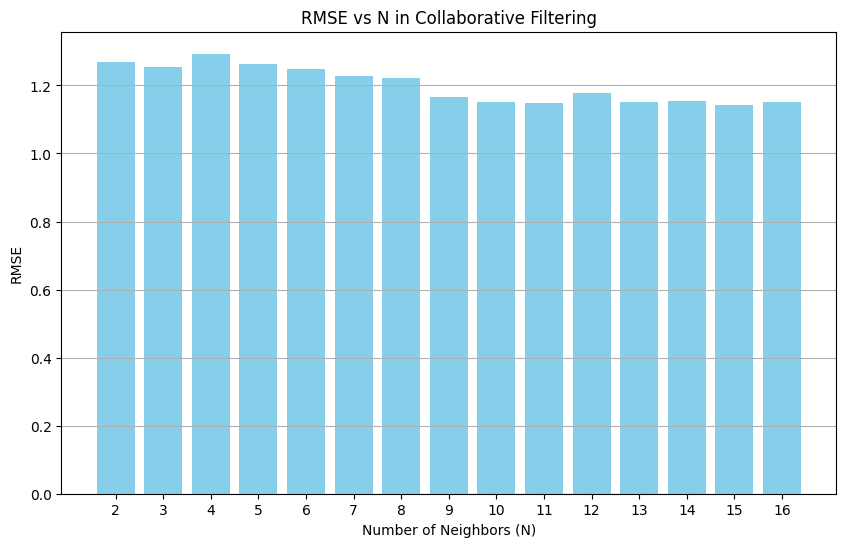

In [ ]:
rmse_results = []

for N in range(2, 17):
    model_N = CollaborativeFiltering(N=N, train_df=train_df)
    model_N.load_model(model_save_path)  # Load saved model

    preds = []
    for row in test_df.collect():
        uid, iid, actual = row["user"], row["item"], row["rating"]

        pred_df = model_N.predict(uid, top_k=100)
        if pred_df is not None:
            score_row = pred_df.filter(F.col("item") == iid).select("predicted_rating").first()
            if score_row:
                preds.append((float(score_row["predicted_rating"]), actual))

    if preds:
        pred_sdf = spark.createDataFrame(preds, ["prediction", "label"])
        evaluator = RegressionEvaluator(metricName="rmse")
        rmse = evaluator.evaluate(pred_sdf)
        rmse_results.append((N, rmse))

# Plot RMSE Results

n_list, rmse_list = zip(*rmse_results)

plt.figure(figsize=(10,6))
plt.bar(n_list, rmse_list, color='skyblue')
plt.xlabel("Number of Neighbors (N)")
plt.ylabel("RMSE")
plt.title("RMSE vs N in Collaborative Filtering")
plt.xticks(n_list)
plt.grid(axis='y')
plt.show()

#Step 6: Export Top-k Recommendations for a User

In [ ]:
sample_user_id = 2
recommendations = cf_model.predict(sample_user_id, top_k=20)

print(f"Top recommendations for User {sample_user_id}:")
recommendations.show()

Top 5 recommendations for User 2:
+----+----------------+
|item|predicted_rating|
+----+----------------+
|  29|             5.0|
| 248|             5.0|
| 438|             5.0|
| 428|             5.0|
| 432|             5.0|
| 433|             5.0|
| 462|             5.0|
|  93|             5.0|
| 128|             5.0|
|   7|       4.7582135|
|  42|             4.5|
| 286|             4.5|
| 335|             4.5|
| 421|             4.5|
| 425|             4.5|
| 426|             4.5|
| 444|             4.5|
| 457|             4.5|
| 385|             4.5|
|  13|             4.0|
+----+----------------+



In [ ]:
# Pick target item (movie ID)
target_item = 190

# Define a fixed list of users
target_users = list(range(2, 17))

predictions_for_item = []

for uid in target_users:
    pred_df = cf_model.predict(uid, top_k=100)
    if pred_df is not None:
        pred_row = pred_df.filter(F.col("item") == target_item).select("predicted_rating").first()
        if pred_row:
            predictions_for_item.append((uid, pred_row["predicted_rating"]))

# Convert to DataFrame
schema = StructType([
    StructField("user", IntegerType(), True),
    StructField("predicted_rating", FloatType(), True),
])
item_predictions_df = spark.createDataFrame(predictions_for_item, schema)

# Show predictions sorted by rating
item_predictions_df.orderBy(F.desc("predicted_rating")).show()

+----+----------------+
|user|predicted_rating|
+----+----------------+
|   9|       4.6140037|
|   8|        3.973658|
|  13|             2.0|
+----+----------------+

